In [ ]:
import argparse, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import reuters

In [ ]:
# constants and hyperparameters
MAX_WORD_INDEX = 10000
EMBEDDING_DIM = 128
BATCH_SIZE = 128
NUM_EPOCHS = 200
NUM_LSTM_UNITS = 30
NUM_GRU_UNITS = 30
DROPOUT_RATE = 0.9
LR = 0.001
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1.0e-8
DECAY = 0.0
VAL_PERC = 0.4
NUM_CLASSES = 46

In [ ]:
lstm_model_name	= 'model_lstm'

history_file_lstm = os.path.join(lstm_model_name, f'history_{lstm_model_name}.csv')
lstm_logdir = os.path.join(lstm_model_name, 'log')
ckpts_lstm = os.path.join(lstm_model_name, 'ckpts')
os.makedirs(lstm_logdir, exist_ok=True)
os.makedirs(ckpts_lstm, exist_ok=True)

In [ ]:
gru_model_name = 'model_gru'

history_file_gru = os.path.join(gru_model_name, f'history_{gru_model_name}.csv')
gru_logdir = os.path.join(gru_model_name, 'log')
ckpts_gru = os.path.join(gru_model_name, 'ckpts')
os.makedirs(gru_logdir, exist_ok=True)
os.makedirs(ckpts_lstm, exist_ok=True)

In [ ]:
# load database using Keras
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = MAX_WORD_INDEX)

In [ ]:
# take a look at the data 

print(f'training set : {train_data.shape}')
print(f'test set: {test_data.shape}')
print('training set example')
print(train_data[0])

training set : (8982,)
test set: (2246,)
training set example
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict(
                        [(value,key) for (key, value) in word_index.items()])
td_index = random.randrange(0, train_data.size)
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[td_index]])
print(decoded_newswire)
print("train label: ", train_labels[td_index])


? qtly div 20 cts vs 20 cts prior pay june one record may 15 reuter 3
train label:  3


In [ ]:
#  print some information on the data
max_seq_len_train = max([len(sequence) for sequence in train_data])
max_seq_len_test = max([len(sequence) for sequence in test_data])
min_seq_len_train = min([len(sequence) for sequence in train_data])
min_seq_len_test = min([len(sequence) for sequence in test_data])
print(f'Maximum train sequence length: {max_seq_len_train}')
print(f'Maximum test sequence length: {max_seq_len_test}')
print(f'Minimum train sequence length: {min_seq_len_train}')
print(f'Minimum test sequence length: {min_seq_len_test}')

Maximum train sequence length: 2376
Maximum test sequence length: 1032
Minimum train sequence length: 13
Minimum test sequence length: 2


In [ ]:
# pad sequences
X_train = keras.preprocessing.sequence.pad_sequences(train_data)
X_test = keras.preprocessing.sequence.pad_sequences(test_data)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (8982, 2376)
X_test shape: (2246, 1032)


In [ ]:
# transform labels  into arrays
y_train = np.asarray(train_labels).astype('float32')
y_test  = np.asarray(test_labels).astype('float32')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

y_train shape: (8982,)
y_test shape: (2246,)


In [ ]:
# build model
lstm_model = keras.models.Sequential(
    [
        keras.layers.Embedding(MAX_WORD_INDEX, EMBEDDING_DIM),
        keras.layers.LSTM(
            units=NUM_LSTM_UNITS,
            dropout=DROPOUT_RATE,
            recurrent_dropout=0,
            return_sequences=True
        ),
        keras.layers.LSTM(
            units=NUM_LSTM_UNITS,
            dropout=DROPOUT_RATE,
            recurrent_dropout=0
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ]
)

print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, None, 30)          19080     
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 46)                1426      
                                                                 
Total params: 1,307,946
Trainable params: 1,307,886
Non-trainable params: 60
_____________________________________________

In [ ]:
gru_model = keras.models.Sequential(
    [
        keras.layers.Embedding(MAX_WORD_INDEX, EMBEDDING_DIM),
        keras.layers.GRU(
            units=NUM_GRU_UNITS,
            dropout=DROPOUT_RATE,
            recurrent_dropout=0,
            return_sequences=True
        ),
        keras.layers.GRU(
            units=NUM_GRU_UNITS, 
            dropout=DROPOUT_RATE, 
            recurrent_dropout=0,
        ), 
        keras.layers.BatchNormalization(),
        keras.layers.Dense(NUM_CLASSES * 2, activation='relu'),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')
        
    ]
)

print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 gru (GRU)                   (None, None, 30)          14400     
                                                                 
 gru_1 (GRU)                 (None, 30)                5580      
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 92)                2852      
                                                                 
 dense_2 (Dense)             (None, 46)                4278      
                                                      

In [ ]:
# set optimizer
opt = keras.optimizers.Adam(
    learning_rate=LR,
    beta_1=BETA1,
    beta_2=BETA2,
    epsilon=EPSILON,
    decay=DECAY)

In [ ]:
# set loss and metrics
loss = keras.losses.sparse_categorical_crossentropy
met = [keras.metrics.sparse_categorical_accuracy]

In [ ]:
# compile model: optimization method, training criterion and metrics
lstm_model.compile(
  optimizer=opt,
  loss=loss,
  metrics=met
)

gru_model.compile(
    optimizer=opt,
    loss=loss,
    metrics=met
)

In [ ]:
# early stop, save best checkpoint
#lsmt model
filepath = ckpts_lstm + '/weights-improvement-{epoch:02d}-{val_sparse_categorical_accuracy:.4f}.hdf5'
lstm_callbacks_list = [
  keras.callbacks.EarlyStopping(
    monitor='sparse_categorical_accuracy',
    patience=50),
  keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    verbose=1),
  keras.callbacks.TensorBoard(
    log_dir=lstm_logdir),
    ]

In [ ]:
# GRU
filepath = ckpts_gru + '/weights-improvement-{epoch:02d}-{val_sparse_categorical_accuracy:.4f}.hdf5'
gru_callbacks_list = [
  keras.callbacks.EarlyStopping(
    monitor='sparse_categorical_accuracy',
    patience=50),
  keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    verbose=1),
  keras.callbacks.TensorBoard(
    log_dir=gru_logdir),
    ]

In [ ]:
# split training data into training and validation
nsamples = X_train.shape[0]
nval_samples = int(VAL_PERC * nsamples)
X_val = X_train[:nval_samples]
partial_X_train = X_train[nval_samples:]
y_val = y_train[:nval_samples]
partial_y_train = y_train[nval_samples:]

print("partial_X_train shape: ", partial_X_train.shape)
print("partial_y_train shape: ", partial_y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

partial_X_train shape:  (5390, 2376)
partial_y_train shape:  (5390,)
X_val shape:  (3592, 2376)
y_val shape:  (3592,)


In [ ]:
# train model
lstm_history = lstm_model.fit(
    partial_X_train,
    partial_y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=lstm_callbacks_list,
    verbose=1
)

Epoch 1/200
43/43 [==============================] - ETA: 0s - loss: 3.4953 - sparse_categorical_accuracy: 0.1891
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.46242, saving model to model_lstm/ckpts/weights-improvement-01-0.4624.hdf5
43/43 [==============================] - 20s 302ms/step - loss: 3.4953 - sparse_categorical_accuracy: 0.1891 - val_loss: 3.3764 - val_sparse_categorical_accuracy: 0.4624
Epoch 2/200
43/43 [==============================] - ETA: 0s - loss: 2.4655 - sparse_categorical_accuracy: 0.4850
Epoch 2: val_sparse_categorical_accuracy improved from 0.46242 to 0.51921, saving model to model_lstm/ckpts/weights-improvement-02-0.5192.hdf5
43/43 [==============================] - 8s 198ms/step - loss: 2.4655 - sparse_categorical_accuracy: 0.4850 - val_loss: 2.8540 - val_sparse_categorical_accuracy: 0.5192
Epoch 3/200
43/43 [==============================] - ETA: 0s - loss: 2.0809 - sparse_categorical_accuracy: 0.5393
Epoch 3: val_sparse_categorical_accu

In [ ]:
# train model
gru_history = gru_model.fit(partial_X_train,
  partial_y_train,
  epochs=NUM_EPOCHS,
  batch_size=BATCH_SIZE,
  validation_data=(X_val, y_val),
  callbacks=gru_callbacks_list,
  verbose=1)

Epoch 1/200
43/43 [==============================] - ETA: 0s - loss: 2.5430 - sparse_categorical_accuracy: 0.3896
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.48859, saving model to model_gru/ckpts/weights-improvement-01-0.4886.hdf5
43/43 [==============================] - 13s 231ms/step - loss: 2.5430 - sparse_categorical_accuracy: 0.3896 - val_loss: 2.1935 - val_sparse_categorical_accuracy: 0.4886
Epoch 2/200
43/43 [==============================] - ETA: 0s - loss: 2.0607 - sparse_categorical_accuracy: 0.4989
Epoch 2: val_sparse_categorical_accuracy improved from 0.48859 to 0.50362, saving model to model_gru/ckpts/weights-improvement-02-0.5036.hdf5
43/43 [==============================] - 9s 216ms/step - loss: 2.0607 - sparse_categorical_accuracy: 0.4989 - val_loss: 2.0655 - val_sparse_categorical_accuracy: 0.5036
Epoch 3/200
43/43 [==============================] - ETA: 0s - loss: 1.9607 - sparse_categorical_accuracy: 0.5160
Epoch 3: val_sparse_categorical_accura

In [ ]:
# save training history
history_df = pd.DataFrame(lstm_history.history)
with open(history_file_lstm, mode='w') as f:
  history_df.to_csv(f)

In [ ]:
history_df = pd.DataFrame(gru_history.history)
with open(history_file_gru, mode='w') as f:
  history_df.to_csv(f)

In [ ]:
# score model using test data
lstm_score, lstm_acc = lstm_model.evaluate(
    X_test, y_test,
    batch_size=BATCH_SIZE)
print('LSTM Test score (loss):', lstm_score)
print('LSTM Test accuracy:', lstm_acc)

gru_score, gru_acc = gru_model.evaluate(
    X_test, y_test,
    batch_size=BATCH_SIZE)
print('GRU Test score (loss):', gru_score)
print('GRU Test accuracy:', gru_acc)

18/18 [==============================] - 1s 38ms/step - loss: 1.8704 - sparse_categorical_accuracy: 0.7275
LSTM Test score (loss): 1.870359182357788
LSTM Test accuracy: 0.7275155782699585
18/18 [==============================] - 1s 32ms/step - loss: 2.5414 - sparse_categorical_accuracy: 0.7048
GRU Test score (loss): 2.541378974914551
GRU Test accuracy: 0.7048085331916809


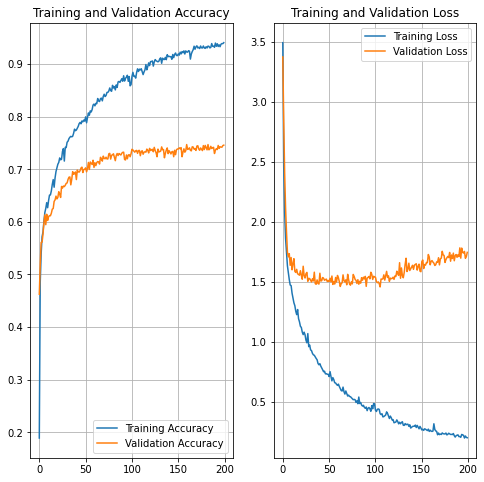

In [ ]:
epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(epochs_range, lstm_history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(epochs_range, lstm_history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(epochs_range, lstm_history.history['loss'], label='Training Loss')
plt.plot(epochs_range, lstm_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

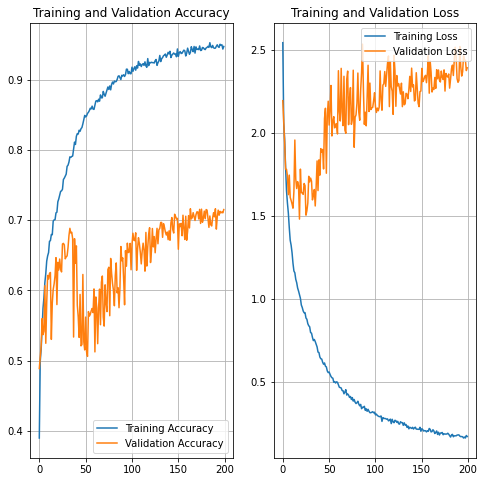

In [ ]:
epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(epochs_range, gru_history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(epochs_range, gru_history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(epochs_range, gru_history.history['loss'], label='Training Loss')
plt.plot(epochs_range, gru_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()